# Florence-2-large sample usage

In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM  
from PIL import Image
import requests
import copy
import torch
%matplotlib inline  

In [2]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
/home/usama-naveed/miniconda3/envs/hf/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_

## define the prediction function

In [3]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

## init image 

In [4]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

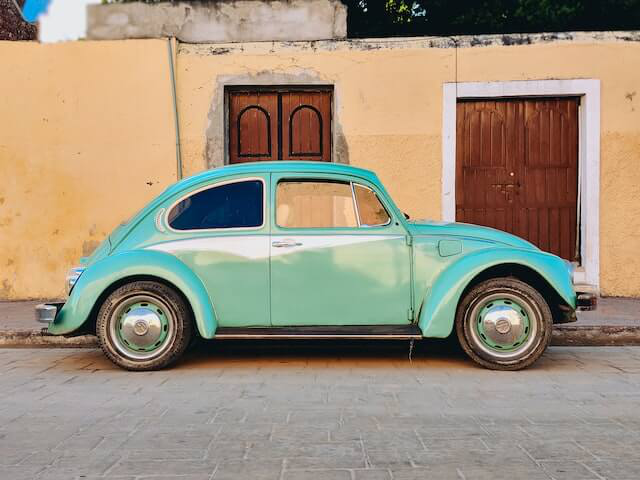

In [58]:
image

# Captioning Using Florence-2  
## Simple Prompts You Can Use

## Simple Caption

# ' < CAPTION >' 

## A little detailed Caption

# <DETAILED_CAPTION>

## A more detailed Caption

# <MORE_DETAILED_CAPTION>


In [64]:
task_prompt = '<CAPTION>'
run_example(task_prompt)

{'<CAPTION>': 'A green car parked in front of a yellow building.'}

In [65]:
task_prompt = '<DETAILED_CAPTION>'
run_example(task_prompt)

{'<DETAILED_CAPTION>': 'The image shows a blue Volkswagen Beetle parked in front of a yellow building with two brown doors, surrounded by trees and a clear blue sky.'}

In [66]:
task_prompt = '<MORE_DETAILED_CAPTION>'
run_example(task_prompt)

{'<MORE_DETAILED_CAPTION>': 'The image shows a vintage Volkswagen Beetle car parked on a cobblestone street in front of a yellow building with two wooden doors. The car is painted in a bright turquoise color and has a sleek, streamlined design. It has two doors on either side of the car, one on top of the other, and a small window on the front. The building appears to be old and dilapidated, with peeling paint and crumbling walls. The sky is blue and there are trees in the background.'}

# This will draw boxes with labels on the image you have provided 


### Object detection

OD results format: 
{'\<OD>':
    {
    'bboxes': [[x1, y1, x2, y2], ...], 
    'labels': ['label1', 'label2', ...]
    } 
}

In [67]:
task_prompt = '<OD>'
results = run_example(task_prompt)
print(results)

{'<OD>': {'bboxes': [[33.599998474121094, 159.59999084472656, 596.7999877929688, 371.7599792480469], [454.0799865722656, 96.23999786376953, 580.7999877929688, 261.8399963378906], [224.95999145507812, 86.15999603271484, 333.7599792480469, 164.39999389648438], [449.5999755859375, 276.239990234375, 554.5599975585938, 370.3199768066406], [91.19999694824219, 280.0799865722656, 198.0800018310547, 370.3199768066406]], 'labels': ['car', 'door', 'door', 'wheel', 'wheel']}}


In [5]:
import matplotlib.pyplot as plt  
import matplotlib.patches as patches  
def plot_bbox(image, data):
   # Create a figure and axes  
    fig, ax = plt.subplots()  
      
    # Display the image  
    ax.imshow(image)  
      
    # Plot each bounding box  
    for bbox, label in zip(data['bboxes'], data['labels']):  
        # Unpack the bounding box coordinates  
        x1, y1, x2, y2 = bbox  
        # Create a Rectangle patch  
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')  
        # Add the rectangle to the Axes  
        ax.add_patch(rect)  
        # Annotate the label  
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))  
      
    # Remove the axis ticks and labels  
    ax.axis('off')  
      
    # Show the plot  
    plt.show()  

In [6]:
plot_bbox(image, results['<OD>'])

NameError: name 'results' is not defined

# Draw Boxes and give Captions on the region. 

### Dense region caption

Dense region caption results format: 
{'\<DENSE_REGION_CAPTION>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['label1', 'label2', ...]}}

In [7]:
task_prompt = '<DENSE_REGION_CAPTION>'
results = run_example(task_prompt)
print(results)

{'<DENSE_REGION_CAPTION>': {'bboxes': [[33.599998474121094, 160.0800018310547, 596.7999877929688, 371.7599792480469], [450.8800048828125, 276.7200012207031, 553.2799682617188, 370.79998779296875], [95.04000091552734, 280.55999755859375, 197.44000244140625, 371.2799987792969]], 'labels': ['turquoise Volkswagen Beetle', 'wheel', 'wheel']}}


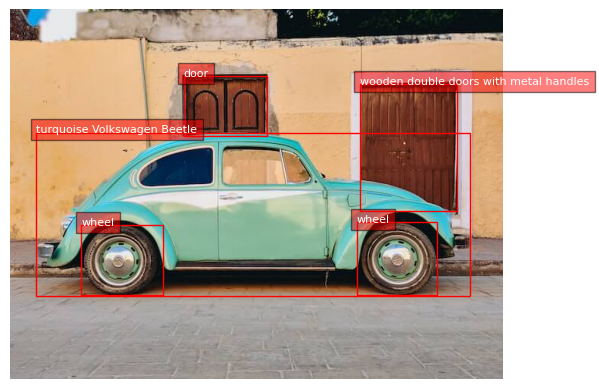

In [27]:
plot_bbox(image, results['<DENSE_REGION_CAPTION>'])

# This will help you draw BBs on a Region seen by the model.

### Region proposal

Region proposal results format: 
{'<REGION_PROPOSAL>' : {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}

In [8]:
task_prompt = '<REGION_PROPOSAL>'
results = run_example(task_prompt)
print(results)

{'<REGION_PROPOSAL>': {'bboxes': [[34.23999786376953, 160.0800018310547, 597.4400024414062, 371.7599792480469], [456.0, 97.68000030517578, 580.1599731445312, 261.8399963378906], [452.1600036621094, 276.7200012207031, 553.9199829101562, 370.79998779296875], [96.31999969482422, 280.55999755859375, 198.72000122070312, 371.2799987792969], [66.87999725341797, 266.6399841308594, 87.36000061035156, 295.91998291015625], [272.32000732421875, 241.67999267578125, 303.67999267578125, 246.95999145507812], [408.6399841308594, 308.3999938964844, 414.3999938964844, 321.3599853515625], [403.5199890136719, 212.39999389648438, 411.1999816894531, 219.59999084472656], [510.3999938964844, 172.0800018310547, 516.1599731445312, 176.39999389648438]], 'labels': ['', '', '', '', '', '', '', '', '']}}


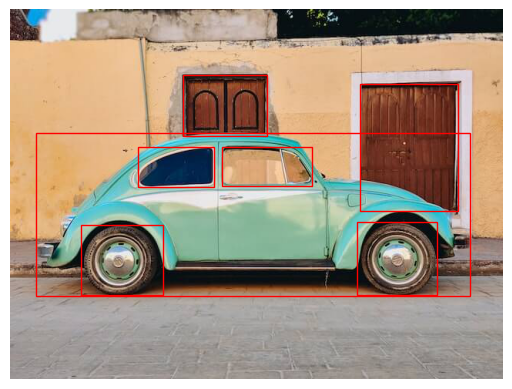

In [29]:
plot_bbox(image, results['<REGION_PROPOSAL>'])

## Run pre-defined tasks that requires additional inputs 

### Phrase Grounding
Phrase grounding results format: 
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}

In [11]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input="Only Rims")
print(results)

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[456.0, 275.7599792480469, 553.9199829101562, 370.79998779296875], [95.68000030517578, 278.6399841308594, 194.239990234375, 371.2799987792969]], 'labels': ['Only Rims', 'Only Rims']}}


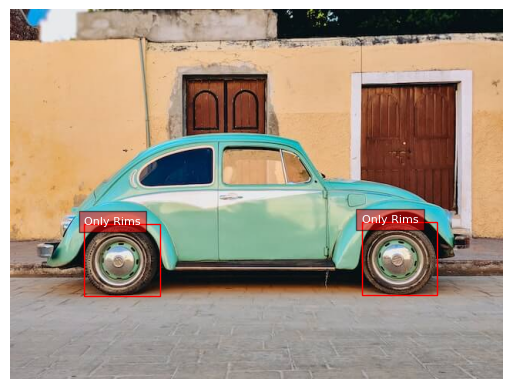

In [12]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### Referring expression segmentation

Referring expression segmentation results format: 
{'\<REFERRING_EXPRESSION_SEGMENTATION>': {'Polygons': [[[polygon]], ...], 'labels': ['', '', ...]}}, one object is represented by a list of polygons. each polygon is [x1, y1, x2, y2, ..., xn, yn]

In [13]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(task_prompt, text_input="a green car")
print(results)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[178.87998962402344, 181.67999267578125, 180.8000030517578, 180.72000122070312, 182.72000122070312, 180.72000122070312, 187.83999633789062, 177.83999633789062, 189.75999450683594, 177.83999633789062, 192.95999145507812, 175.9199981689453, 194.87998962402344, 175.9199981689453, 198.0800018310547, 174.0, 200.63999938964844, 173.0399932861328, 203.83999633789062, 172.0800018310547, 207.0399932861328, 170.63999938964844, 209.59999084472656, 169.67999267578125, 214.0800018310547, 168.72000122070312, 217.9199981689453, 167.75999450683594, 221.75999450683594, 166.8000030517578, 226.239990234375, 165.83999633789062, 230.72000122070312, 164.87998962402344, 237.1199951171875, 163.9199981689453, 244.1599884033203, 162.95999145507812, 253.1199951171875, 162.0, 265.2799987792969, 161.0399932861328, 311.3599853515625, 161.0399932861328, 329.2799987792969, 162.0, 338.239990234375, 162.95999145507812, 345.2799987792969, 163.9199981689453, 350.3999

In [16]:
from PIL import Image, ImageDraw, ImageFont 
import random
import numpy as np
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']
def draw_polygons(image, prediction, fill_mask=False):  
    """  
    Draws segmentation masks with polygons on an image.  
  
    Parameters:  
    - image_path: Path to the image file.  
    - prediction: Dictionary containing 'polygons' and 'labels' keys.  
                  'polygons' is a list of lists, each containing vertices of a polygon.  
                  'labels' is a list of labels corresponding to each polygon.  
    - fill_mask: Boolean indicating whether to fill the polygons with color.  
    """  
    # Load the image  
   
    draw = ImageDraw.Draw(image)  
      
   
    # Set up scale factor if needed (use 1 if not scaling)  
    scale = 1  
      
    # Iterate over polygons and labels  
    for polygons, label in zip(prediction['polygons'], prediction['labels']):  
        color = random.choice(colormap)  
        fill_color = random.choice(colormap) if fill_mask else None  
          
        for _polygon in polygons:  
            _polygon = np.array(_polygon).reshape(-1, 2)  
            if len(_polygon) < 3:  
                print('Invalid polygon:', _polygon)  
                continue  
              
            _polygon = (_polygon * scale).reshape(-1).tolist()  
              
            # Draw the polygon  
            if fill_mask:  
                draw.polygon(_polygon, outline=color, fill=fill_color)  
            else:  
                draw.polygon(_polygon, outline=color)  
              
            # Draw the label text  
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)  
  
    # Save or display the image  
    #image.show()  # Display the image  
    display(image)

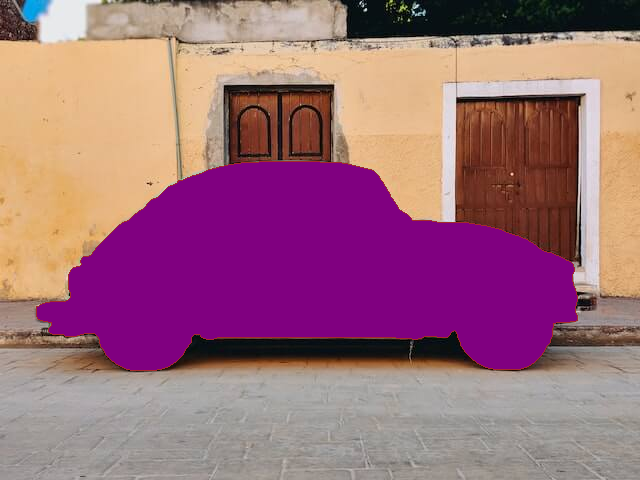

In [17]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)  

### region to segmentation


with additional region as inputs, format is '\<loc_x1>\<loc_y1>\<loc_x2>\<loc_y2>', [x1, y1, x2, y2] is the quantized corrdinates in [0, 999]. 

In [18]:
task_prompt = '<REGION_TO_SEGMENTATION>'
results = run_example(task_prompt, text_input="<loc_702><loc_575><loc_866><loc_772>")
print(results)

{'<REGION_TO_SEGMENTATION>': {'polygons': [[[470.0799865722656, 288.239990234375, 473.91998291015625, 285.3599853515625, 477.1199951171875, 283.44000244140625, 479.03997802734375, 282.47998046875, 480.9599914550781, 282.47998046875, 484.1600036621094, 280.55999755859375, 486.7200012207031, 279.6000061035156, 489.91998291015625, 278.6399841308594, 495.03997802734375, 277.67999267578125, 512.3200073242188, 277.67999267578125, 514.8800048828125, 278.6399841308594, 518.0800170898438, 279.6000061035156, 521.2799682617188, 281.5199890136719, 523.2000122070312, 281.5199890136719, 525.1199951171875, 283.44000244140625, 528.3200073242188, 284.3999938964844, 530.8800048828125, 286.32000732421875, 534.0800170898438, 288.239990234375, 543.0399780273438, 297.3599853515625, 544.9599609375, 300.239990234375, 546.8800048828125, 303.1199951171875, 550.0800170898438, 309.3599853515625, 551.3599853515625, 312.239990234375, 552.0, 315.1199951171875, 553.2799682617188, 319.44000244140625, 553.2799682617188

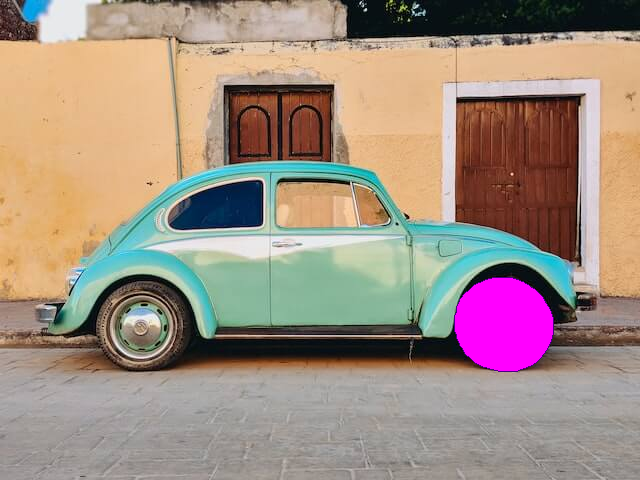

In [19]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REGION_TO_SEGMENTATION>'], fill_mask=True)  

### Open vocabulary detection

open vocabulary detection can detect both objects and ocr texts. 

results format: 

{ '\<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[x1, y1, x2, y2], [x1, y1, x2, y2], ...]], 'bboxes_labels': ['label_1', 'label_2', ..],
'polygons': [[[x1, y1, x2, y2, ..., xn, yn], [x1, y1, ..., xn, yn]], ...], 'polygons_labels': ['label_1', 'label_2', ...]
}}

In [22]:
task_prompt = '<OPEN_VOCABULARY_DETECTION>'
results = run_example(task_prompt, text_input="back bumper")
print(results)

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[32.959999084472656, 298.79998779296875, 66.87999725341797, 325.1999816894531]], 'bboxes_labels': ['back bumper'], 'polygons': [], 'polygons_labels': []}}


In [23]:
def convert_to_od_format(data):  
    """  
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.  
  
    Parameters:  
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.  
  
    Returns:  
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.  
    """  
    # Extract bounding boxes and labels  
    bboxes = data.get('bboxes', [])  
    labels = data.get('bboxes_labels', [])  
      
    # Construct the output format  
    od_results = {  
        'bboxes': bboxes,  
        'labels': labels  
    }  
      
    return od_results  

In [24]:
bbox_results  = convert_to_od_format(results['<OPEN_VOCABULARY_DETECTION>'])

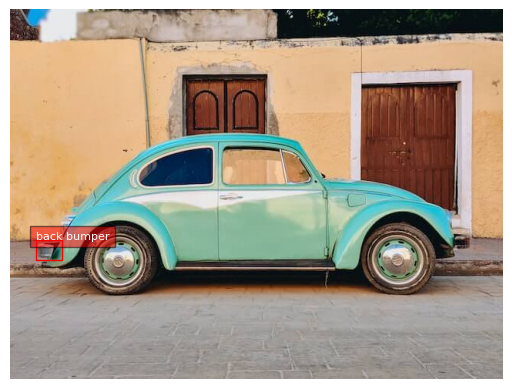

In [25]:
plot_bbox(image, bbox_results)

### region to texts

In [42]:
task_prompt = '<REGION_TO_CATEGORY>'
results = run_example(task_prompt, text_input="<loc_52><loc_332><loc_932><loc_774>")
print(results)

{'<REGION_TO_CATEGORY>': 'car<loc_52><loc_332><loc_932><loc_774>'}


In [43]:
task_prompt = '<REGION_TO_DESCRIPTION>'
results = run_example(task_prompt, text_input="<loc_52><loc_332><loc_932><loc_774>")
print(results)

{'<REGION_TO_DESCRIPTION>': 'turquoise Volkswagen Beetle<loc_52><loc_332><loc_932><loc_774>'}


## ocr related tasks

In [26]:
url = "http://ecx.images-amazon.com/images/I/51UUzBDAMsL.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

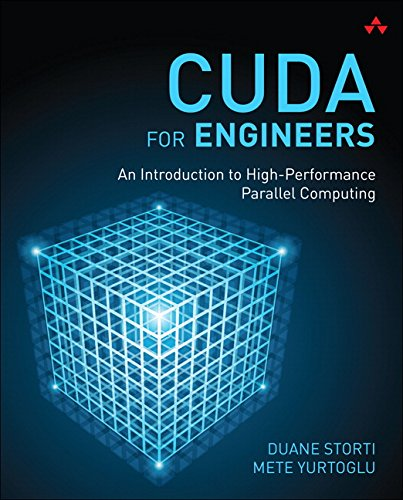

In [27]:
image

In [28]:
task_prompt = '<OCR>'
run_example(task_prompt)

{'<OCR>': 'CUDAFOR ENGINEERSAn Introduction to High-PerformanceParallel ComputingDUANE STORTIMETE YURTOGLU'}

In [29]:
task_prompt = '<OCR_WITH_REGION>'
results = run_example(task_prompt)
print(results)
# ocr results format
# {'OCR_WITH_REGION': {'quad_boxes': [[x1, y1, x2, y2, x3, y3, x4, y4], ...], 'labels': ['text1', ...]}}

{'<OCR_WITH_REGION>': {'quad_boxes': [[167.0435028076172, 50.25, 374.9914855957031, 50.25, 374.9914855957031, 114.75, 167.0435028076172, 114.75], [144.8784942626953, 120.75, 374.9914855957031, 120.75, 374.9914855957031, 149.25, 144.8784942626953, 149.25], [115.86249542236328, 165.25, 377.0065002441406, 166.25, 377.0065002441406, 184.25, 115.86249542236328, 183.25], [239.9864959716797, 184.25, 377.0065002441406, 186.25, 377.0065002441406, 204.25, 239.9864959716797, 202.25], [266.5845031738281, 441.25, 377.0065002441406, 441.25, 377.0065002441406, 456.25, 266.5845031738281, 456.25], [251.27049255371094, 460.25, 377.0065002441406, 460.25, 377.0065002441406, 475.25, 251.27049255371094, 475.25]], 'labels': ['</s>CUDA', 'FOR ENGINEERS', 'An Introduction to High-Performance', 'Parallel Computing', 'DUANE STORTI', 'METE YURTOGLU']}}


In [30]:
def draw_ocr_bboxes(image, prediction, scale=1):
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",
        
                    fill=color)
       
    display(image)

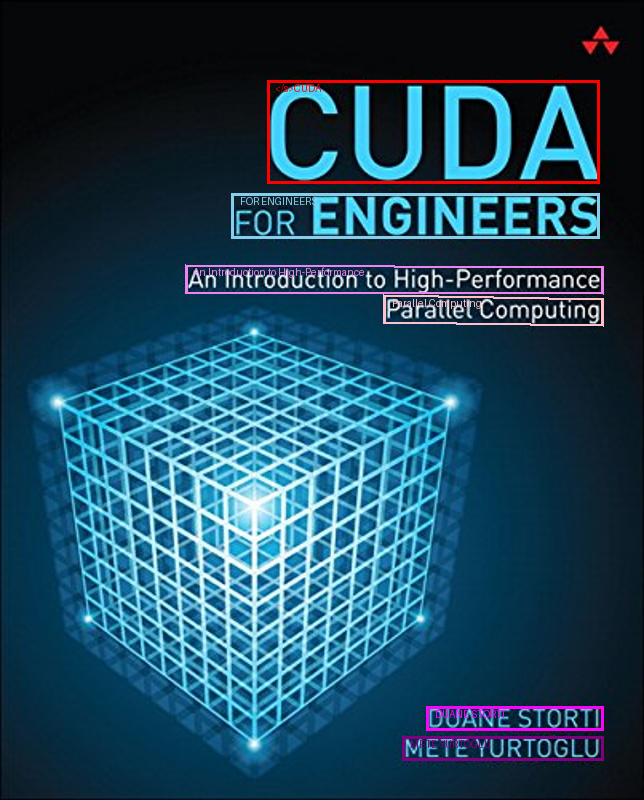

In [31]:
output_image = copy.deepcopy(image)
w, h = output_image.size
scale = 800 / max(w, h)
new_output_image = output_image.resize((int(w * scale), int(h * scale)))
draw_ocr_bboxes(new_output_image, results['<OCR_WITH_REGION>'], scale=scale)  

## Cascaded tasks

### Caption + Phrase Grounding 

results format: 

{
 '\<CAPTION': pure_text, 
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}
}

In [32]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

In [33]:
task_prompt = '<CAPTION>'
results = run_example(task_prompt)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input)
results['<CAPTION>'] = text_input

In [34]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[34.880001068115234,
    158.63999938964844,
    583.3599853515625,
    374.6399841308594],
   [0.3199999928474426,
    4.079999923706055,
    639.0399780273438,
    305.03997802734375]],
  'labels': ['A green car', 'a yellow building']},
 '<CAPTION>': 'A green car parked in front of a yellow building.'}

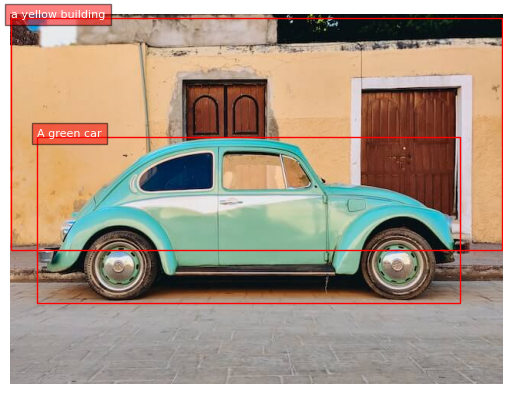

In [35]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### Detailed Caption + Phrase Grounding 

results format: 

{
 '\<DETAILED_CAPTION': pure_text, 
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}
}

In [36]:
task_prompt = '<DETAILED_CAPTION>'
results = run_example(task_prompt)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input)
results['<DETAILED_CAPTION>'] = text_input

In [37]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[34.23999786376953,
    158.16000366210938,
    583.3599853515625,
    374.1600036621094],
   [0.3199999928474426,
    4.079999923706055,
    639.0399780273438,
    304.0799865722656],
   [454.0799865722656, 94.31999969482422, 582.0800170898438, 264.239990234375],
   [224.3199920654297,
    84.72000122070312,
    335.03997802734375,
    165.83999633789062],
   [0.3199999928474426,
    1.1999999284744263,
    639.0399780273438,
    42.959999084472656],
   [0.3199999928474426,
    1.1999999284744263,
    103.36000061035156,
    43.91999816894531],
   [0.3199999928474426,
    1.1999999284744263,
    638.3999633789062,
    42.959999084472656],
   [345.91998291015625,
    1.1999999284744263,
    639.0399780273438,
    39.119998931884766]],
  'labels': ['a blue Volkswagen Beetle',
   'a yellow building',
   'brown doors',
   'brown doors',
   'The sky',
   'The sky',
   'a few green trees',
   'a few green trees']},
 '<DETAILED_CAPTION>': 'The im

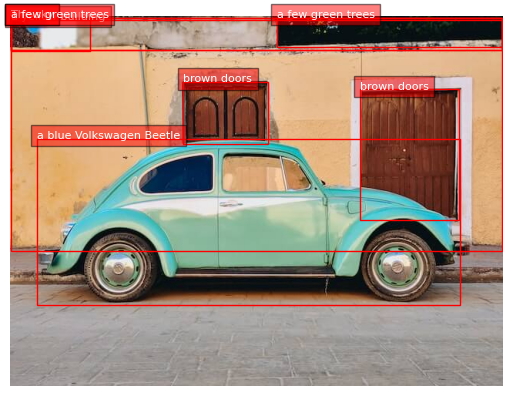

In [38]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### More Detailed Caption + Phrase Grounding 

results format: 

{
 '\<MORE_DETAILED_CAPTION': pure_text, 
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}
}

In [39]:
task_prompt = '<MORE_DETAILED_CAPTION>'
results = run_example(task_prompt)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input)
results['<MORE_DETAILED_CAPTION>'] = text_input

In [40]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[35.52000045776367,
    157.67999267578125,
    581.4400024414062,
    372.7200012207031],
   [0.3199999928474426,
    340.0799865722656,
    639.0399780273438,
    479.2799987792969],
   [454.7200012207031,
    93.83999633789062,
    582.0800170898438,
    263.2799987792969],
   [224.3199920654297,
    84.23999786376953,
    335.03997802734375,
    164.39999389648438],
   [35.52000045776367,
    157.1999969482422,
    581.4400024414062,
    372.7200012207031],
   [454.7200012207031,
    93.83999633789062,
    581.4400024414062,
    263.2799987792969],
   [224.3199920654297,
    84.72000122070312,
    335.03997802734375,
    163.9199981689453],
   [165.44000244140625,
    177.36000061035156,
    266.55999755859375,
    232.0800018310547],
   [0.3199999928474426,
    5.039999961853027,
    639.0399780273438,
    301.67999267578125],
   [0.3199999928474426, 0.7199999690055847, 639.0399780273438, 42.0],
   [20.799999237060547,
    0.7199999690

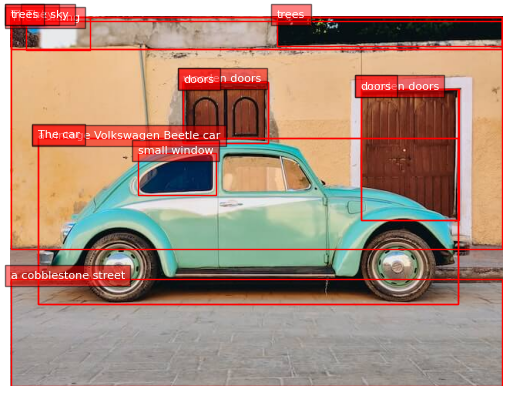

In [41]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])